In [1]:
import numpy as np
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
import diffrax

from soromox.systems import SystemState
from soromox.systems.tendon_actuated_planar_pcs import TendonActuatedPlanarPCS
from NMPC import NMPC

In [2]:
num_segments = 1
params = {
    "th0": jnp.array(jnp.pi / 2, dtype=jnp.float64),  # initial orientation angle [rad]
    "L": 1e-1 * jnp.ones((num_segments,)),
    "r": 2e-2 * jnp.ones((num_segments,)),
    "rho": 1070 * jnp.ones((num_segments,)),  # Volumetric density of Dragon Skin 20 [kg/m^3],
    "g": jnp.array([0.0, 9.81]),  # gravitational acceleration [m/s^2] UP!
    "E": 5e3 * jnp.ones((num_segments,)),  # Elastic modulus [Pa]
    "G": 1e3 * jnp.ones((num_segments,)),  # Shear modulus [Pa]
    "d": 2e-2 * jnp.array([[1.0, -1.0]]).repeat(num_segments, axis=0),  # distance of tendons from the central axis [m]
}
params["D"] = 1e-3 * jnp.diag((jnp.repeat(jnp.array([[1e0, 1e3, 1e3]]), num_segments, axis=0) * params["L"][:, None]).flatten())

robot = TendonActuatedPlanarPCS(num_segments=num_segments, params=params)

In [3]:
key = jax.random.PRNGKey(4)
q0 = jax.random.normal(key, shape=int(robot.num_active_strains)) * jnp.repeat(jnp.array([5.0 * jnp.pi, 0.1, 0.05])[None, :], num_segments, axis=0).flatten()
qd0 = jnp.zeros_like(q0)
initial_state = SystemState(t=0.0, y=jnp.concatenate([q0, qd0], axis=0))

In [ ]:
trajectoy_sim = robot.rollout_to(initial_state=initial_state, t1=1.0, solver_dt=1e-4, save_dt=1e-3, solver=diffrax.Tsit5())
pos_sim = []
for q in jnp.split(trajectoy_sim.y, 2, axis=1)[0]:
    pos_sim.append(robot.forward_kinematics_tips(q))
pos_sim = jnp.array(pos_sim)
t_sim = trajectoy_sim.t

In [5]:
q_euler = [q0]
qd_euler = [qd0]
pos_euler = [robot.forward_kinematics_tips(q0)]
t_euler = [0.0]
dt_euler = 1e-3
f_euler = jax.jit(lambda x: x + dt_euler * robot.forward_dynamics(None, x))
while t_euler[-1] < 1.0:
    x_next = f_euler(jnp.concatenate([q_euler[-1], qd_euler[-1]], axis=0))
    t_euler.append(t_euler[-1] + dt_euler)
    q_euler.append(jnp.split(x_next, 2)[0])
    qd_euler.append(jnp.split(x_next, 2)[1])
    pos_euler.append(robot.forward_kinematics_tips(q_euler[-1]))
pos_euler = jnp.array(pos_euler)

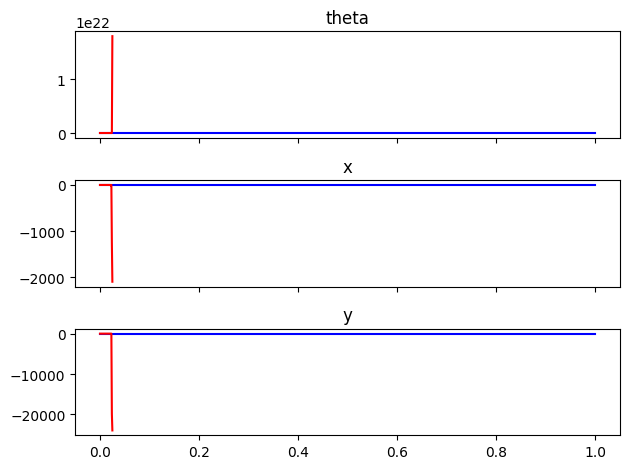

In [6]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].title.set_text("theta")
ax[0].plot(t_sim, pos_sim[:, -1, 0], c='b', label='RK simulation')
ax[0].plot(t_euler, pos_euler[:, -1, 0], c='r', label='Euler')
ax[1].title.set_text("x")
ax[1].plot(t_sim, pos_sim[:, -1, 1], c='b', label='RK simulation')
ax[1].plot(t_euler, pos_euler[:, -1, 1], c='r', label='Euler')
ax[2].title.set_text("y")
ax[2].plot(t_sim, pos_sim[:, -1, 2], c='b', label='RK simulation')
ax[2].plot(t_euler, pos_euler[:, -1, 2], c='r', label='Euler')
fig.tight_layout()
plt.show()

In [7]:
s_batch = jnp.linspace(0.0, robot.L.sum(), 100)

pos_sim_batch = []
for i, q in enumerate(jnp.split(trajectoy_sim.y, 2, axis=1)[0]):
    if i % 10 == 0:
        pos_sim_batch.append(robot.forward_kinematics_batched(q, s_batch))
pos_sim_batch = np.array(pos_sim_batch)

pos_euler_batch = []
for i, q in enumerate(q_euler):
    if i % 10 == 0:
        pos_euler_batch.append(robot.forward_kinematics_batched(q, s_batch))
pos_euler_batch = np.array(pos_euler_batch)

print(pos_sim_batch.shape, pos_euler_batch.shape)

(101, 100, 3) (101, 100, 3)


In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pos_1 = pos_sim_batch
pos_2 = pos_euler_batch

n_t, n_s, _ = pos_1.shape
assert pos_2.shape[0] == n_t

# --- 2. Setup Plot and Update Function ---

# Determine the overall bounds for the combined data
combined_pos = np.concatenate((pos_1, pos_2), axis=1)
data_min = np.min(combined_pos[:, :, 1:])
data_max = np.max(combined_pos[:, :, 1:])
buffer = (data_max - data_min) * 0.1

# Initialize plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title(f'Comparison of {n_s} Points from Two Batches', fontsize=14)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--')
ax.set_xlim(data_min - buffer, data_max + buffer)
ax.set_ylim(data_min - buffer, data_max + buffer)
ax.yaxis.set_inverted(True)

# Initial scatter plots
# pos_1 (blue)
colors_1 = ['blue'] * n_s 
scat_1 = ax.scatter(pos_1[0, :, 1], pos_1[0, :, 2], s=100, c=colors_1, marker='o')

# pos_2 (red)
colors_2 = ['red'] * n_s
scat_2 = ax.scatter(pos_2[0, :, 1], pos_2[0, :, 2], s=100, c=colors_2, marker='o')

# Legend and Time Step Annotation
time_template = 'Time Step = %d / %d'
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, backgroundcolor='w')

def update(frame):
    """Updates the position of both scatter plots for the given frame (time step)"""
    # Update Batch 1 (Blue)
    X1, Y1 = pos_1[frame, :, 1], pos_1[frame, :, 2]
    scat_1.set_offsets(list(zip(X1, Y1)))
    
    # Update Batch 2 (Red)
    X2, Y2 = pos_2[frame, :, 1], pos_2[frame, :, 2]
    scat_2.set_offsets(list(zip(X2, Y2)))
    
    # Update time text
    time_text.set_text(time_template % (frame + 1, n_t))
    
    # Return both scatter objects and the text object
    return scat_1, scat_2, time_text

# --- 3. Create Animation and Display in Notebook ---

ani = FuncAnimation(fig, update, frames=n_t, blit=True, interval=50)

# Close the figure
plt.close(fig)

# Convert the animation to an HTML string and display it
HTML(ani.to_jshtml())

In [9]:
controller = NMPC(30, 1e-2, robot)

AttributeError: 'TendonActuatedPlanarPCS' object has no attribute 'num_links'